# MEGALINE. Análisis de los planes y comportamiento de clientes


## Contenido <a id='back'></a>

* [Introducción](#intro) 
* [1. Exploración de los datos](#data_review)
* [2. Preprocesamiento de datos](#data_preprocessing)
* [3. Análisis estadístico datos](#eda)
* [4. Prueba de hipótesis](#hypotheses)
* [Conclusiones](#end)


## Introducción <a id='intro'></a>

En este proyecto la compañía móvil Megaline requiere un análisis estadístico de los planes que ofrece y el comportamiento de sus clientes, su departamento comercial quiere saber cuál de los planes genera más ingresos para poder ajustar el presupuesto de publicidad, la empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate.

## Objetivo

Analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos y responder las siguientes preguntas:

1. ¿Quiénes son y dónde se encuentran los clientes?
2. ¿Qué tarifa usan los clientes, la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018?

[Regresar a Contenido](#back)

## 1. Exploración de datos <a id='data_review'></a>

## Inicialización

In [ ]:
# Cargar todas las librerías
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.stats import levene

## Cargar los datos

In [354]:
# Carga los archivos de datos en diferentes DataFrames
data_calls= pd.read_csv('/datasets/megaline_calls.csv')
data_internet=pd.read_csv('/datasets/megaline_internet.csv')
data_messages=pd.read_csv('/datasets/megaline_messages.csv')
data_plans=pd.read_csv('/datasets/megaline_plans.csv')
data_users=pd.read_csv('/datasets/megaline_users.csv')

[Regresar a Contenido](#back)

## 2. Preprocesamiento de datos <a id='data_preprocessing'></a>

###  Planes

In [355]:
data_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [356]:
# Imprime una muestra de los datos para los planes
data_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Como podemos observar en la tabla, los datos que tenemos lo sdebemos unificar, ya que en los precios tenemos cuanto se paga por gb, mientras que cuando se observa la cantidad de internet que viene incluido en el plan se maneja en mb, por lo que es de suma importancia hacer la conversión en este caso de mb a gb.

#### a. Corregir los datos

In [357]:
data_plans['mb_per_month_included']=data_plans['mb_per_month_included']/1024
data_plans=data_plans.rename(columns={'mb_per_month_included':'gb_per_month_included'})
data_plans

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


#### b. Enriquecer los datos

En este caso, no se considera necesario el agregar alguna otra columna o información al dataframe de los planes de servicios.

### Usuarios

In [358]:
# Imprime la información general/resumen sobre el DataFrame de los usuarios
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [359]:
# Imprime una muestra de los datos para los usuarios
data_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN




En esta ocasión podemos apreciar que en las columnas reg_date y churn_date se reportan como datos de tipo obj y hay que convertirlo en datetime.

También se aprecian datos ausentes en esta pultima columna churn_date tenemos datos ausentes, no se pueden eliminar porque estos refieren líneas activas cuando se recabaron los datos. 



In [360]:
data_users['plan'].value_counts()

surf        339
ultimate    161
Name: plan, dtype: int64

#### a. Corregir datos

En esta parte se corrigieron los tipos de datos, en donde las fechas se pasaron al tipo datetime64.

In [361]:
data_users['reg_date']=pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')
data_users['churn_date']=pd.to_datetime(data_users['churn_date'], format='%Y-%m-%d')
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


#### b. Enriquecer datos

En este caso, no se considera necesario el agregar alguna otra column o información al dataframe de los usuarios.

### Llamadas

In [362]:
# Imprime la información/resumen general sobre el DataFrame de las llamadas
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [363]:
# Imprime una muestra de datos para llamadas
data_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22




Podemos apreciar que los datos que manejan fechas de la columna call_date tienen el tipo de datos obj los cuales hay que cambiar por tipo datetime.


#### a. Corregir datos

In [364]:
data_calls['call_date']=pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [365]:
data_calls['duration']=data_calls['duration'].apply(np.ceil)
data_calls=data_calls.astype({'duration':'int64'})
data_calls['duration'],data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.2+ MB


(0          9
 1         14
 2         15
 3          6
 4          5
           ..
 137730     9
 137731    11
 137732     9
 137733     1
 137734    14
 Name: duration, Length: 137735, dtype: int64,
 None)

#### b. Enriquecer datos

In [366]:
data_calls['month']=pd.DatetimeIndex(data_calls['call_date']).month
data_calls=data_calls.astype({'month':'int64'})
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
 4   month      137735 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 5.3+ MB


### Mensajes

In [ ]:
# Imprime la información/resumen general sobre el DataFrame de los mensajes
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [368]:
# Imprime una muestra de datos para los mensajes
data_messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


#### a. Corregir datos

In [369]:
data_messages['message_date']=pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')


#### b. Enriquecer datos

In [370]:
data_messages['month']=pd.DatetimeIndex(data_messages['message_date']).month
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.3+ MB


### Internet

In [371]:
# Imprime la información/resumen general sobre el DataFrame de los mensajes
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [372]:
# Imprime una muestra de datos para el tráfico de internet
data_internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


#### a. Corregir datos

In [373]:
data_internet['session_date']=pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')
data_internet['mb_used']=data_internet['mb_used']/1024
data_internet.info(), data_internet['mb_used']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


(None,
 0         0.087754
 1         0.000000
 2         0.644922
 3         0.264639
 4         0.859590
             ...   
 104820    0.212949
 104821    0.297578
 104822    0.285889
 104823    0.000000
 104824    0.740537
 Name: mb_used, Length: 104825, dtype: float64)

#### b. Enriquecer datos

In [374]:

data_internet['month']=pd.DatetimeIndex(data_internet['session_date']).month
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   month         104825 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 4.0+ MB


[Regresar a Contenido](#back)

## 3. Análisis estadístico de datos <a id='eda'></a>

## Estudiar las condiciones del plan

In [375]:
# Imprime las condiciones del plan y asegúrate de que te resulten claros
data_plans

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


## Agregar datos por usuario



In [376]:
# Calcula el número de llamadas hechas por cada usuario por mes. Guarda el resultado.
calls_users_mensual=data_calls.pivot_table(index=['user_id','month'], values='id', aggfunc='count')
calls_users_mensual.head()

id
user_id month    
1000    12     16
1001    8      27
        9      49
        10     65
        11     64

In [377]:
# Calcula la cantidad de minutos que usó cada usuario por mes. Guarda el resultado.
minutes_users_men=data_calls.pivot_table(index=['user_id','month'], values='duration', aggfunc='sum')
minutes_users_men.head()

duration
user_id month          
1000    12          124
1001    8           182
        9           315
        10          393
        11          426

In [378]:
# Calcula el número de mensajes enviados por cada usuario por mes. Guarda el resultado.
messages_users_men=data_messages.pivot_table(index=['user_id','month'], values='id', aggfunc='count')
messages_users_men.head()

id
user_id month    
1000    12     11
1001    8      30
        9      44
        10     53
        11     36

In [379]:
# Calcula el volumen del trafico de internet usado por cada usuario por mes. Guarda el resultado.
gb_users_men=data_internet.pivot_table(index=['user_id','month'], values='mb_used', aggfunc='sum')
gb_users_men=gb_users_men.apply(np.ceil)
gb_users_men=gb_users_men.astype({'mb_used':'int64'})
gb_users_men.head()

mb_used
user_id month         
1000    12           2
1001    8            7
        9           14
        10          22
        11          19

En este caso,  realizamos pequeñas tablas en donde se representa cada uno de los servicios con indices de id de usuario y los meses.

In [380]:
# Combina los datos para las llamadas, minutos, mensajes e internet con base en el user_id y el mes
monthly_consumed_user=calls_users_mensual.merge(minutes_users_men , on=['user_id', 'month'], how='outer')
monthly_consumed_user=monthly_consumed_user.merge(messages_users_men , on=['user_id', 'month'], how='outer')
monthly_consumed_user=monthly_consumed_user.merge(gb_users_men , on=['user_id', 'month'], how='outer').reset_index()

monthly_consumed_user=monthly_consumed_user.merge(data_users , on=['user_id'], how='outer')

monthly_consumed_user=monthly_consumed_user.rename(columns={'plan':'plan_name','id_x':'calls_mensual','duration':'minutes_mensual','id_y':'msn_mensual','mb_used':'gb_mensual'})
monthly_consumed_user

,user_id,month,calls_mensual,minutes_mensual,msn_mensual,gb_mensual,first_name,last_name,age,city,reg_date,plan_name,churn_date
0,1000,12.0,16.0,124.0,11.0,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,8.0,27.0,182.0,30.0,7.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1001,9.0,49.0,315.0,44.0,14.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
3,1001,10.0,65.0,393.0,53.0,22.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
4,1001,11.0,64.0,426.0,36.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,1307,NaN,NaN,NaN,NaN,NaN,Kristopher,Lang,28,"Boston-Cambridge-Newton, MA-NH MSA",2018-12-31,surf,NaT
2299,1319,NaN,NaN,NaN,NaN,NaN,Eliseo,Carson,21,"Colorado Springs, CO MSA",2018-06-17,surf,NaT
2300,1378,NaN,NaN,NaN,NaN,NaN,Mckinley,Clayton,22,"Denver-Aurora-Lakewood, CO MSA",2018-12-17,surf,NaT
2301,1463,NaN,NaN,NaN,NaN,NaN,Dinorah,Simmons,30,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-11-27,ultimate,NaT


In [381]:
# Combina los datos para las llamadas, minutos, mensajes e internet con base en el user_id y el mes
monthly_consumed_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 0 to 2302
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          2303 non-null   int64         
 1   month            2293 non-null   float64       
 2   calls_mensual    2258 non-null   float64       
 3   minutes_mensual  2258 non-null   float64       
 4   msn_mensual      1806 non-null   float64       
 5   gb_mensual       2277 non-null   float64       
 6   first_name       2303 non-null   object        
 7   last_name        2303 non-null   object        
 8   age              2303 non-null   int64         
 9   city             2303 non-null   object        
 10  reg_date         2303 non-null   datetime64[ns]
 11  plan_name        2303 non-null   object        
 12  churn_date       160 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(5), int64(2), object(4)
memory usage: 251.9+ KB


Como podemos apreciar, mediante el metodo merge se unieron los datos para obtener un nuevo dataframe y mediante el metodo info() podemos observar que se agregó la información correctamente, la mayoría de la información se agregó con el indice basado en el mes y el id de usuario, sin embargo, para agregar la información de los usuarios, se tuvo que soolamente basarse en un índice de id de usuario, también para poder trabajar mejor se cambiaron los nombres de algunas columnas para que sea más entendible.

In [382]:
# Añade la información del plan
monthly_consumed_user=monthly_consumed_user.merge(data_plans , on=['plan_name'], how='outer')
monthly_consumed_user.head()

,user_id,month,calls_mensual,minutes_mensual,msn_mensual,gb_mensual,first_name,last_name,age,city,reg_date,plan_name,churn_date,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,12.0,16.0,124.0,11.0,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,1000,30.0,3000,70,7,0.01,0.01
1,1006,11.0,2.0,10.0,15.0,3.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,1000,30.0,3000,70,7,0.01,0.01
2,1006,12.0,9.0,59.0,139.0,32.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,1000,30.0,3000,70,7,0.01,0.01
3,1008,10.0,71.0,476.0,21.0,17.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaT,1000,30.0,3000,70,7,0.01,0.01
4,1008,11.0,63.0,446.0,37.0,24.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaT,1000,30.0,3000,70,7,0.01,0.01


In [383]:
monthly_consumed_user['msn_mensual']=monthly_consumed_user['msn_mensual'].fillna(0)
monthly_consumed_user['calls_mensual']=monthly_consumed_user['calls_mensual'].fillna(0)
monthly_consumed_user['minutes_mensual']=monthly_consumed_user['minutes_mensual'].fillna(0)
monthly_consumed_user['gb_mensual']=monthly_consumed_user['gb_mensual'].fillna(0)
monthly_consumed_user

,user_id,month,calls_mensual,minutes_mensual,msn_mensual,gb_mensual,first_name,last_name,age,city,reg_date,plan_name,churn_date,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,12.0,16.0,124.0,11.0,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,1000,30.0,3000,70,7,0.01,0.01
1,1006,11.0,2.0,10.0,15.0,3.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,1000,30.0,3000,70,7,0.01,0.01
2,1006,12.0,9.0,59.0,139.0,32.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,1000,30.0,3000,70,7,0.01,0.01
3,1008,10.0,71.0,476.0,21.0,17.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaT,1000,30.0,3000,70,7,0.01,0.01
4,1008,11.0,63.0,446.0,37.0,24.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaT,1000,30.0,3000,70,7,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,1143,NaN,0.0,0.0,0.0,0.0,Lorina,Stevens,69,"Cincinnati, OH-KY-IN MSA",2018-10-26,surf,NaT,50,15.0,500,20,10,0.03,0.03
2299,1307,NaN,0.0,0.0,0.0,0.0,Kristopher,Lang,28,"Boston-Cambridge-Newton, MA-NH MSA",2018-12-31,surf,NaT,50,15.0,500,20,10,0.03,0.03
2300,1319,NaN,0.0,0.0,0.0,0.0,Eliseo,Carson,21,"Colorado Springs, CO MSA",2018-06-17,surf,NaT,50,15.0,500,20,10,0.03,0.03
2301,1378,NaN,0.0,0.0,0.0,0.0,Mckinley,Clayton,22,"Denver-Aurora-Lakewood, CO MSA",2018-12-17,surf,NaT,50,15.0,500,20,10,0.03,0.03


In [384]:
# Calcula el ingreso mensual para cada usuario
monthly_consumed_user['usd_min_extras']= (monthly_consumed_user['minutes_mensual']-monthly_consumed_user['minutes_included'])*monthly_consumed_user['usd_per_minute']
monthly_consumed_user['usd_min_extras']=(monthly_consumed_user['usd_min_extras']+abs(monthly_consumed_user['usd_min_extras']))/2

monthly_consumed_user['usd_msn_extras']= (monthly_consumed_user['msn_mensual']-monthly_consumed_user['messages_included'])*monthly_consumed_user['usd_per_message']
monthly_consumed_user['usd_msn_extras']= (monthly_consumed_user['usd_msn_extras']+ abs(monthly_consumed_user['usd_msn_extras']))/2

monthly_consumed_user['usd_gb_extras']= (monthly_consumed_user['gb_mensual']-monthly_consumed_user['gb_per_month_included'])*monthly_consumed_user['usd_per_gb']
monthly_consumed_user['usd_gb_extras']= (monthly_consumed_user['usd_gb_extras']+ abs(monthly_consumed_user['usd_gb_extras']))/2

monthly_consumed_user['pay_usd_extra']=monthly_consumed_user['usd_min_extras']+monthly_consumed_user['usd_msn_extras']+monthly_consumed_user['usd_gb_extras']
monthly_consumed_user['pay_usd_total']= monthly_consumed_user['pay_usd_extra']+monthly_consumed_user['usd_monthly_pay']

monthly_consumed_user.info()
monthly_consumed_user


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 0 to 2302
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                2303 non-null   int64         
 1   month                  2293 non-null   float64       
 2   calls_mensual          2303 non-null   float64       
 3   minutes_mensual        2303 non-null   float64       
 4   msn_mensual            2303 non-null   float64       
 5   gb_mensual             2303 non-null   float64       
 6   first_name             2303 non-null   object        
 7   last_name              2303 non-null   object        
 8   age                    2303 non-null   int64         
 9   city                   2303 non-null   object        
 10  reg_date               2303 non-null   datetime64[ns]
 11  plan_name              2303 non-null   object        
 12  churn_date             160 non-null    datetime64[ns]
 13  mes

,user_id,month,calls_mensual,minutes_mensual,msn_mensual,gb_mensual,first_name,last_name,age,city,...,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,usd_min_extras,usd_msn_extras,usd_gb_extras,pay_usd_extra,pay_usd_total
0,1000,12.0,16.0,124.0,11.0,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",...,3000,70,7,0.01,0.01,0.0,0.0,0.0,0.0,70.0
1,1006,11.0,2.0,10.0,15.0,3.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",...,3000,70,7,0.01,0.01,0.0,0.0,0.0,0.0,70.0
2,1006,12.0,9.0,59.0,139.0,32.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",...,3000,70,7,0.01,0.01,0.0,0.0,14.0,14.0,84.0
3,1008,10.0,71.0,476.0,21.0,17.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",...,3000,70,7,0.01,0.01,0.0,0.0,0.0,0.0,70.0
4,1008,11.0,63.0,446.0,37.0,24.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",...,3000,70,7,0.01,0.01,0.0,0.0,0.0,0.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,1143,NaN,0.0,0.0,0.0,0.0,Lorina,Stevens,69,"Cincinnati, OH-KY-IN MSA",...,500,20,10,0.03,0.03,0.0,0.0,0.0,0.0,20.0
2299,1307,NaN,0.0,0.0,0.0,0.0,Kristopher,Lang,28,"Boston-Cambridge-Newton, MA-NH MSA",...,500,20,10,0.03,0.03,0.0,0.0,0.0,0.0,20.0
2300,1319,NaN,0.0,0.0,0.0,0.0,Eliseo,Carson,21,"Colorado Springs, CO MSA",...,500,20,10,0.03,0.03,0.0,0.0,0.0,0.0,20.0
2301,1378,NaN,0.0,0.0,0.0,0.0,Mckinley,Clayton,22,"Denver-Aurora-Lakewood, CO MSA",...,500,20,10,0.03,0.03,0.0,0.0,0.0,0.0,20.0


In [385]:
monthly_consumed_user.query("user_id == 1001")

,user_id,month,calls_mensual,minutes_mensual,msn_mensual,gb_mensual,first_name,last_name,age,city,...,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,usd_min_extras,usd_msn_extras,usd_gb_extras,pay_usd_extra,pay_usd_total
724,1001,8.0,27.0,182.0,30.0,7.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,500,20,10,0.03,0.03,0.0,0.00,0.0,0.00,20.00
725,1001,9.0,49.0,315.0,44.0,14.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,500,20,10,0.03,0.03,0.0,0.00,0.0,0.00,20.00
726,1001,10.0,65.0,393.0,53.0,22.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,500,20,10,0.03,0.03,0.0,0.09,70.0,70.09,90.09
727,1001,11.0,64.0,426.0,36.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,500,20,10,0.03,0.03,0.0,0.00,40.0,40.00,60.00
728,1001,12.0,56.0,412.0,44.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,500,20,10,0.03,0.03,0.0,0.00,40.0,40.00,60.00


## Estudia el comportamiento del usuario

### Llamadas

In [386]:
#Compara la duración promedio de llamadas por cada plan por cada mes. Dibuja una gráfica de barras para visualizarlo.
duration_mean_per_plan_month=monthly_consumed_user.groupby(['month', 'plan_name'])['minutes_mensual']
duration_mean=duration_mean_per_plan_month.mean().reset_index()


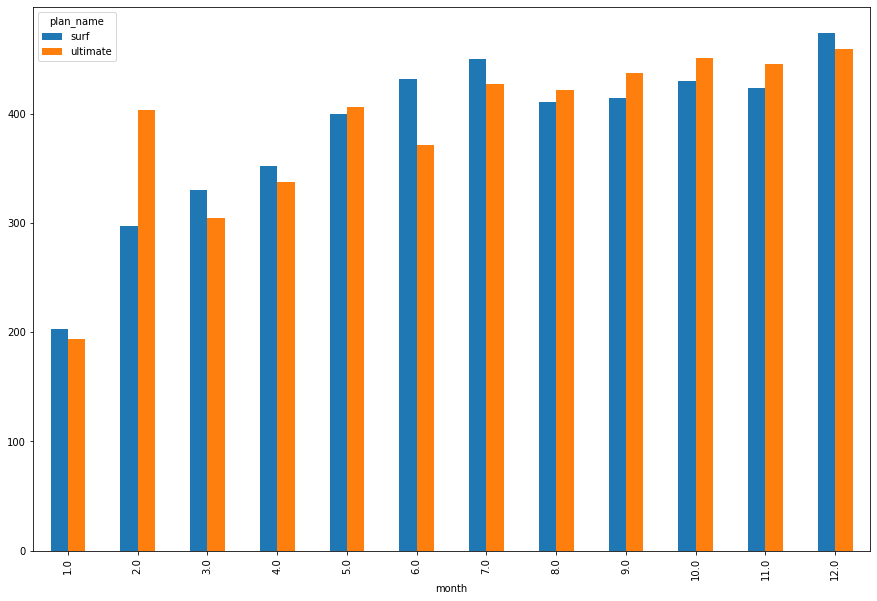

In [387]:
duration_month=monthly_consumed_user.pivot_table(index=['month'], columns=['plan_name'], values='minutes_mensual', aggfunc='mean')
duration_month.plot(kind='bar',figsize=(15,10))
plt.show()

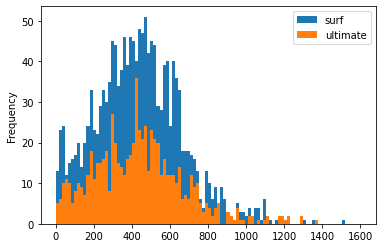

In [388]:
# Compara el número de minutos que los usuarios de cada plan requieren cada mes. Traza un histograma.
plan_type=['surf','ultimate']
for plan in plan_type:
    monthly_consumed_user[monthly_consumed_user['plan_name']==plan]['minutes_mensual'].plot(kind='hist', bins=100, range=(1,1600))
    plt.legend(plan_type)

In [389]:
#media de duración de llamadas por mes y plan
duration_mean

,month,plan_name,minutes_mensual
0,1.0,surf,203.000000
1,1.0,ultimate,193.500000
2,2.0,surf,297.000000
3,2.0,ultimate,403.142857
4,3.0,surf,330.000000
5,3.0,ultimate,304.250000
6,4.0,surf,351.540000
7,4.0,ultimate,336.857143
8,5.0,surf,399.584416
9,5.0,ultimate,406.241379


In [390]:
monthly_consumed_user.groupby(['month'])['minutes_mensual'].mean()

month
1.0     196.666667
2.0     343.437500
3.0     321.171429
4.0     347.197183
5.0     401.405660
6.0     411.604167
7.0     442.472222
8.0     413.562232
9.0     421.378571
10.0    436.221574
11.0    430.100000
12.0    469.091684
Name: minutes_mensual, dtype: float64

In [391]:
# varianza de duración de llamadas por mes 
monthly_consumed_user.pivot_table(index=['month'], values='minutes_mensual', aggfunc='var')

,minutes_mensual
month,
1.0,13135.866667
2.0,61567.329167
3.0,43378.499160
4.0,45620.531992
5.0,54950.510063
6.0,45086.240822
7.0,64525.781347
8.0,53926.747188
9.0,49735.899181


![boxplot_mes](https://i.ibb.co/nbWbm0c/output.png)
*Imagen de ejemplo agregada por el revisor de código


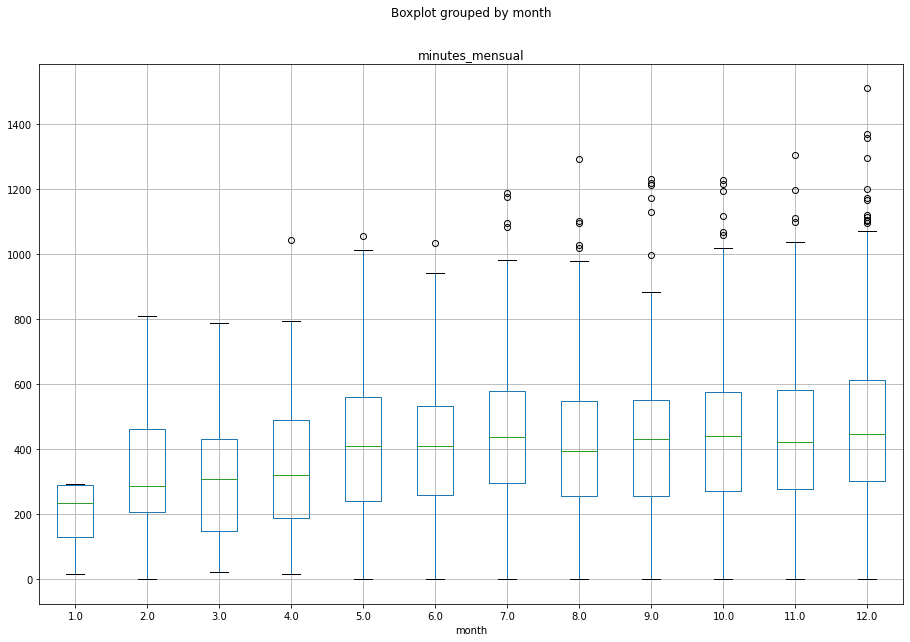

In [392]:
#Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas.
monthly_consumed_user.boxplot(column='minutes_mensual', by='month',figsize=(15,10))
plt.show()  



Podemos observar que la duración promedio de las llamadas en cada plan por cada mes es muy similar en todos los meses y sin importar de que plan se trata, no hay una diferencia significativa, debido a esto su varianza es muy cercana a cero, ya que también no hay variación entre planes, ya que la duración de las llamadas era similar tanto en el plan Surf y en el Ultimate, por lo tanto, en este rubro el comportamiento de los usuarios con respecto a la duración de las llamadas no varía mucho. Sin embargo, en el caso de número de minutos que los usuarios utilizaban mensualmente, podemos observar que el consumo de minutos incrementa conforme al mes del año, observándose que los usuarios del plan surf consumen más minutos que los del plan ultimate.En el histograma podemos observar que los usuarios de ambos planes utilizan en promedio 400 minutos al mes, que es donde vemos una mayor concentración en el histograma. La varianza por planes, no tiene una gran diferencia, sin embargo, si consideramos la varianza de la duración de llamada con respecto al mes, si hay cambios en la varianza.

por lo que podemos observar que el patrón entre los planes no varia, pero las cantidades si, ya que cada uno de los plane sofrecen diferentes cantidades de minutos.

### Mensajes

In [393]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
msn_user_plan_month=monthly_consumed_user.pivot_table(index=['month','plan_name'], values='msn_mensual', aggfunc='mean')


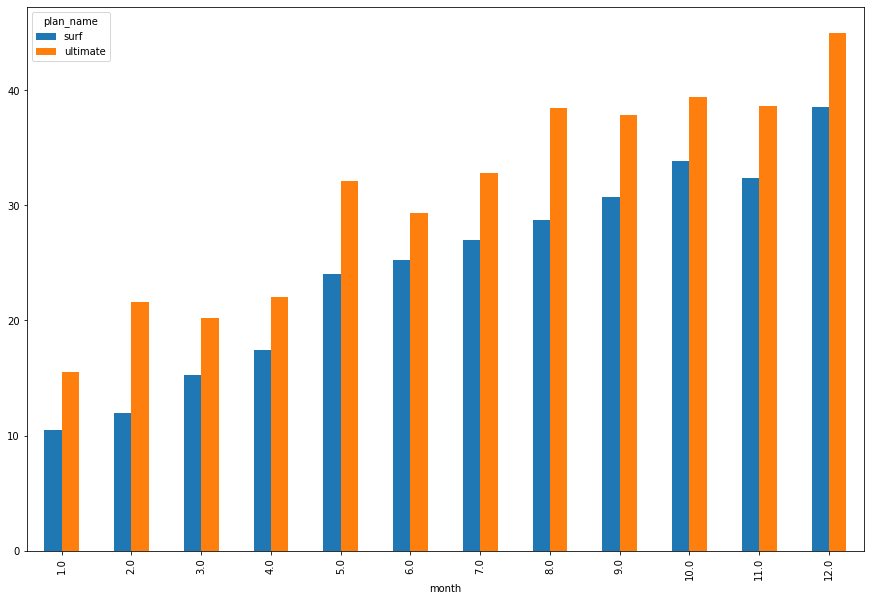

In [394]:
msn_month=monthly_consumed_user.pivot_table(index=['month'], columns=['plan_name'], values='msn_mensual', aggfunc='mean')
msn_month.plot(kind='bar',figsize=(15,10))
plt.show()

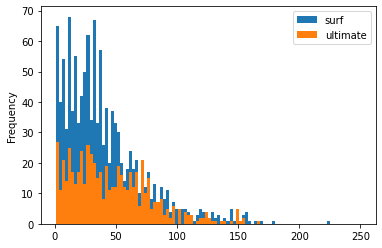

In [395]:
for plan in plan_type:
    monthly_consumed_user[monthly_consumed_user['plan_name']==plan]['msn_mensual'].plot(kind='hist', bins=100, range=(1,250))
plt.legend(plan_type)
plt.show()

In [396]:
monthly_consumed_user.pivot_table(index='plan_name', values='msn_mensual', aggfunc='mean')

,msn_mensual
plan_name,
surf,31.041165
ultimate,37.343923


In [397]:
monthly_consumed_user.pivot_table(index='plan_name', values='msn_mensual', aggfunc='var')

,msn_mensual
plan_name,
surf,1126.118076
ultimate,1209.827612


In [398]:
#media de mensajes por mes y plan
msn_user_plan_month

msn_mensual
month plan_name             
1.0   surf         10.500000
      ultimate     15.500000
2.0   surf         12.000000
      ultimate     21.571429
3.0   surf         15.260870
      ultimate     20.250000
4.0   surf         17.400000
      ultimate     22.047619
5.0   surf         24.012987
      ultimate     32.103448
6.0   surf         25.298969
      ultimate     29.340426
7.0   surf         27.033058
      ultimate     32.830508
8.0   surf         28.777778
      ultimate     38.478873
9.0   surf         30.762887
      ultimate     37.895349
10.0  surf         33.839662
      ultimate     39.443396
11.0  surf         32.385159
      ultimate     38.606299
12.0  surf         38.600629
      ultimate     45.006623

In [399]:
# varianza de duración de llamadas por mes y plana
monthly_consumed_user.pivot_table(index=['month'], values='msn_mensual', aggfunc='var')

,msn_mensual
month,
1.0,238.966667
2.0,421.229167
3.0,441.734454
4.0,511.148491
5.0,972.291105
6.0,893.706245
7.0,938.051397
8.0,1095.446130
9.0,1025.442281


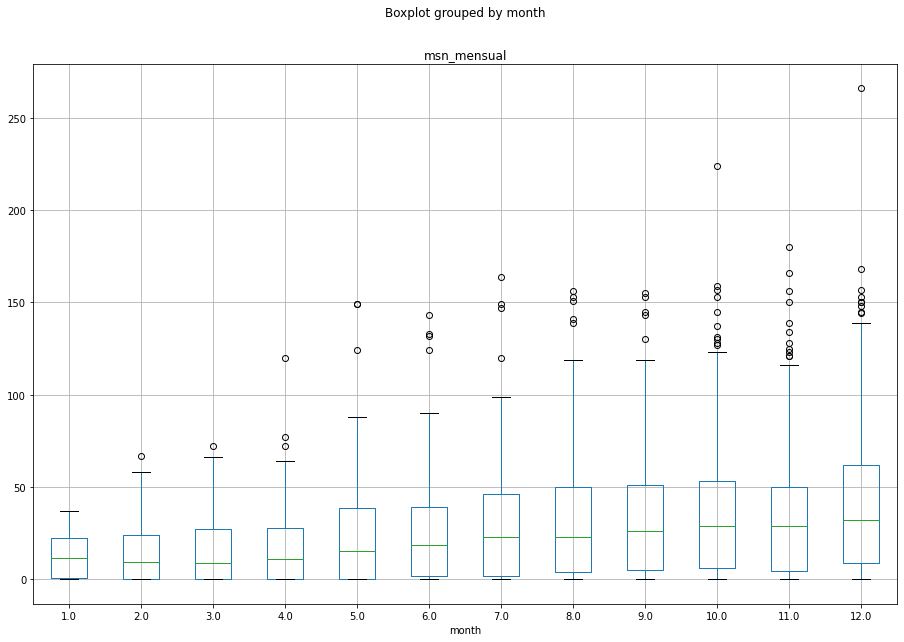

In [400]:
monthly_consumed_user.boxplot(column='msn_mensual', by='month',figsize=(15,10))
plt.show()


En este caso de los mensajes podemos observar que el consumo de los usuarios al mes tiene un comportamiento ascendente conforme el mes del año, el patrón es el mimo en ambos planes y observamos que es normal que el consumo de los mensajes es mayor en el plan surf. Podemos observar que la varianza tiene un valor elevado, podemos observar que muchos de los usuarios no utilizaban este servicio, por lo que el número 0 de uso de mensajes tiene muchos datos, y el número de mensajes más usado esta entre 0 a 25 , por lo que se puede apreciar que este es un servicio poco utilizado por los usuarios. Las varianzas difieren, conforme van pasando los meses o avanza el año, podemos observar que la varianza aaumenta.

### Internet

In [401]:
# Compara la cantidad de tráfico de internet consumido por usuarios por plan
gb_user_plan_month=monthly_consumed_user.pivot_table(index=['month','plan_name'], values='gb_mensual', aggfunc='mean')


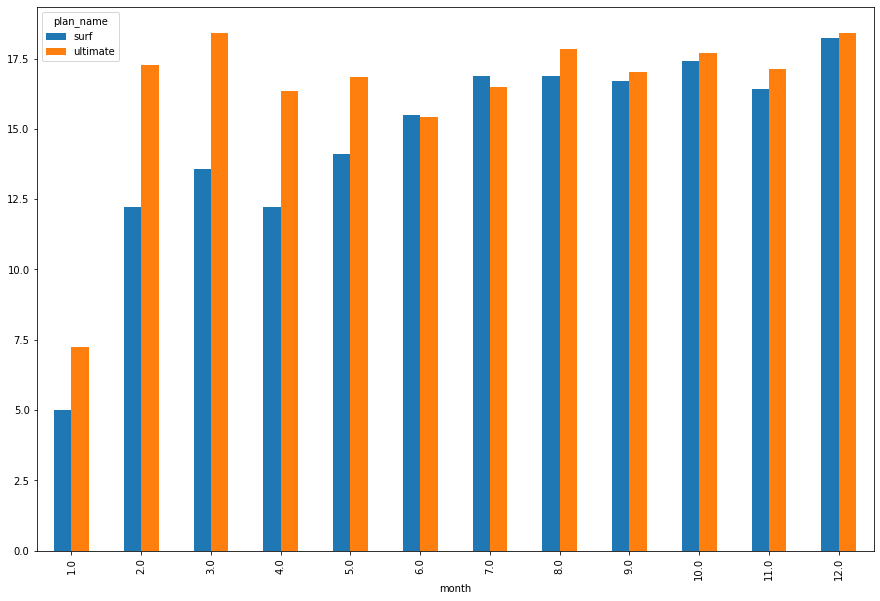

In [402]:
gb_month=monthly_consumed_user.pivot_table(index=['month'], columns=['plan_name'], values='gb_mensual', aggfunc='mean')
gb_month.plot(kind='bar',figsize=(15,10))
plt.show()

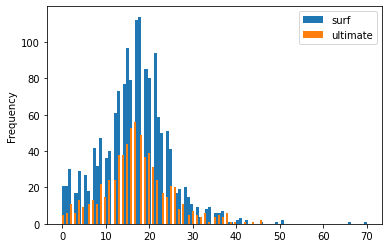

In [403]:
for plan in plan_type:
    monthly_consumed_user[monthly_consumed_user['plan_name']==plan]['gb_mensual'].plot(kind='hist', bins=100)
plt.legend(plan_type)
plt.show()

In [404]:
monthly_consumed_user.pivot_table(index='plan_name', values='gb_mensual', aggfunc='mean')

,gb_mensual
plan_name,
surf,16.607346
ultimate,17.211326


In [405]:
monthly_consumed_user.pivot_table(index='plan_name', values='gb_mensual', aggfunc='var')

,gb_mensual
plan_name,
surf,62.402126
ultimate,60.153067


In [406]:
#media de internet por mes y plan
gb_user_plan_month

gb_mensual
month plan_name            
1.0   surf         5.000000
      ultimate     7.250000
2.0   surf        12.222222
      ultimate    17.285714
3.0   surf        13.565217
      ultimate    18.416667
4.0   surf        12.220000
      ultimate    16.333333
5.0   surf        14.116883
      ultimate    16.862069
6.0   surf        15.484536
      ultimate    15.425532
7.0   surf        16.876033
      ultimate    16.491525
8.0   surf        16.882716
      ultimate    17.845070
9.0   surf        16.690722
      ultimate    17.011628
10.0  surf        17.409283
      ultimate    17.716981
11.0  surf        16.431095
      ultimate    17.118110
12.0  surf        18.238994
      ultimate    18.397351

In [407]:
# varianza de duración de llamadas por mes
monthly_consumed_user.pivot_table(index=['month'], values='gb_mensual', aggfunc='var')

,gb_mensual
month,
1.0,13.900000
2.0,43.995833
3.0,91.710924
4.0,67.449497
5.0,58.077628
6.0,54.208576
7.0,62.065642
8.0,67.274937
9.0,48.482322


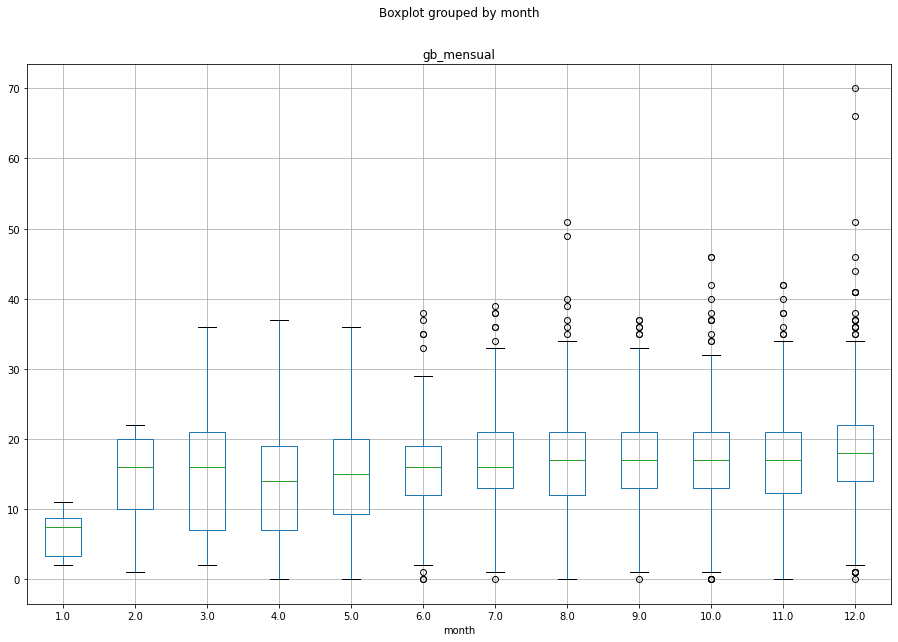

In [408]:
monthly_consumed_user.boxplot(column='gb_mensual', by='month',figsize=(15,10))
plt.show()



En este caso podemos observar que el consumo de gb mensualmente incrementar conforme pasa los meses, por lo que el consumo del servicio es mayor a final del año, patrón que se ha observado en todos los servicios. Podemos observar que en ambos casos la mayoría de los usuarios utiliza de 15 a 20 gb, en el caso del plan Surf este contiene 15 gb para el consumo del cliente, mientras que el plan Ultimate trae 30gb, y podemos observar que los usuarios del plan Surf excede en mayor número su límite , también se puede apreciar que una cantidad considerable excede los límites del servicio, a simple vista podemos decir que es el servicio más utilizado por los usuarios y por esto hay una mayor población que hace supera el límite de los gb utilizados por los usuarios. Las varianzas difieren, conforme van pasando los meses o avanza el año, podemos observar que la varianza aumenta.

## Ingreso

In [409]:
pay_extra_user_plan_month=monthly_consumed_user.pivot_table(index=['month','plan_name'], values='pay_usd_extra', aggfunc='sum')


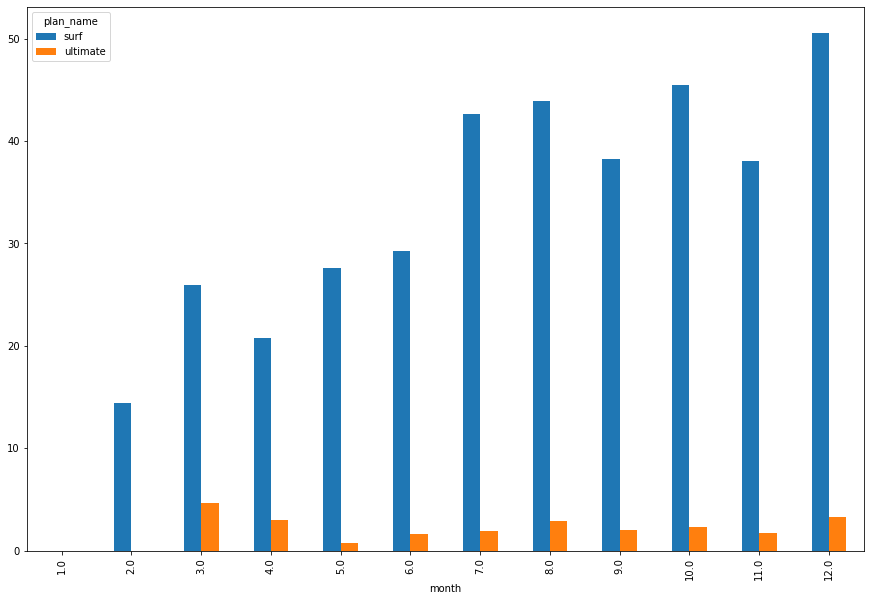

In [410]:
income_month=monthly_consumed_user.pivot_table(index=['month'], columns=['plan_name'], values='pay_usd_extra', aggfunc='mean')
income_month.plot(kind='bar',figsize=(15,10))
plt.show()

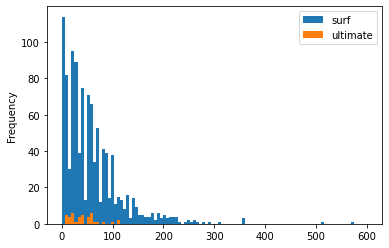

In [411]:
for plan in plan_type:
    monthly_consumed_user[monthly_consumed_user['plan_name']==plan]['pay_usd_extra'].plot(kind='hist', bins=100, range=(1,600))
plt.legend(plan_type)
plt.show()

In [412]:
monthly_consumed_user.pivot_table(index='plan_name', values='pay_usd_extra', aggfunc='mean')

,pay_usd_extra
plan_name,
surf,40.551729
ultimate,2.301105


In [413]:
extra_surf=monthly_consumed_user.query('plan_name == "surf"')['pay_usd_extra'].mean()
extra_surf

40.55172894236859

In [414]:
extra_ultimate=monthly_consumed_user.query('plan_name == "ultimate"')['pay_usd_extra'].mean()
extra_ultimate

2.3011049723756907

In [415]:
monthly_consumed_user.pivot_table(index='plan_name', values='pay_usd_extra', aggfunc='var')

,pay_usd_extra
plan_name,
surf,3062.446864
ultimate,129.159556


In [416]:
surf_usd_extra=monthly_consumed_user.query('plan_name == "surf"')['pay_usd_extra']
np.var(surf_usd_extra)

3060.5073785813724

In [417]:
ultimate_usd_extra=monthly_consumed_user.query('plan_name == "ultimate"')['pay_usd_extra']
np.var(ultimate_usd_extra)

128.98115900003052

In [418]:
#media de duración de llamadas por mes y plan
pay_extra_user_plan_month

pay_usd_extra
month plan_name               
1.0   surf                0.00
      ultimate            0.00
2.0   surf              129.57
      ultimate            0.00
3.0   surf              596.65
      ultimate           56.00
4.0   surf             1035.53
      ultimate           63.00
5.0   surf             2127.37
      ultimate           21.00
6.0   surf             2839.80
      ultimate           77.00
7.0   surf             5163.56
      ultimate          112.00
8.0   surf             7116.85
      ultimate          203.00
9.0   surf             7424.67
      ultimate          175.00
10.0  surf            10764.83
      ultimate          245.00
11.0  surf            10755.21
      ultimate          217.00
12.0  surf            16077.14
      ultimate          497.00

In [419]:
# varianza de duración de llamadas por mes
monthly_consumed_user.pivot_table(index=['month'], values='pay_usd_extra', aggfunc='var')

,pay_usd_extra
month,
1.0,0.000000
2.0,282.820723
3.0,1130.421727
4.0,939.938209
5.0,1573.400155
6.0,1528.462577
7.0,2375.469246
8.0,2895.246937
9.0,1867.386739


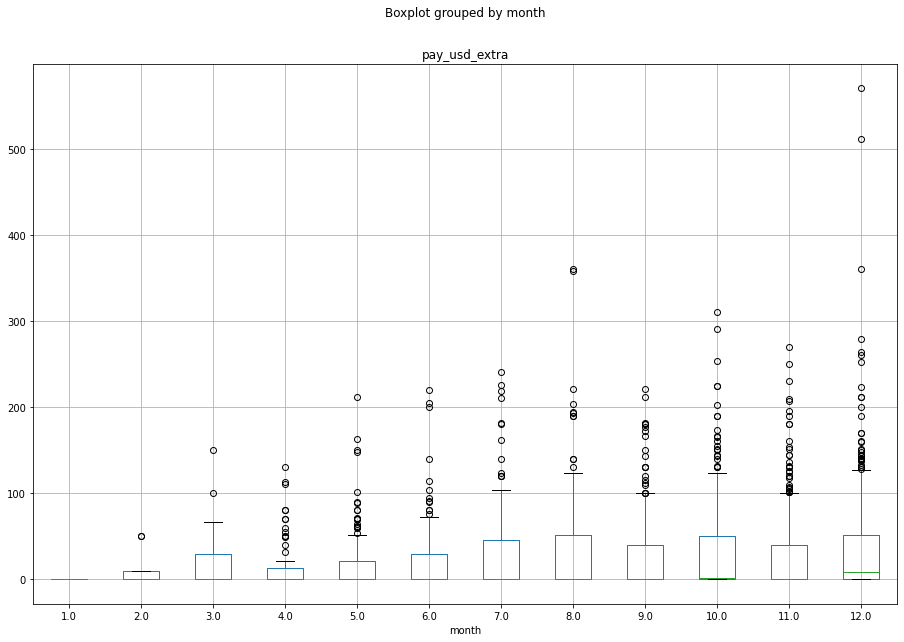

In [420]:
monthly_consumed_user.boxplot(column='pay_usd_extra', by='month',figsize=(15,10))
plt.show()

Podemos observar que como se esperaba el mes de diciembre es en donde los usuarios superan más el límite de sus servicios y por lo tanto se obtiene una mayor cantidad de ingresos extras. Con el Histograma se aprecia que la cantidad de ingresos extras en el plan sur es mucho mayor que los que genera el plan ultimate, la cantidad que más pagan extra los usuarios del plan surf es aproximadamente 30 dólares, que es donde se puede apreciar la mayor cantidad de población en el histograma.

[Regresar a Contenido](#back) 

## 4. Prueba de hipótesis <a id='hypotheses'></a>

### Primera hipótesis

En esta ocasión vamos a comenzar revisando la primera hipotesis nula, la cual es: 
"Los ingresos del plan surf son iguales a los ingresos del plan ultimate", para esto se utilizara metodo scipy.stats.ttest_ind (array, popmean), para probar tu hipótesis de que las medias de dos poblaciones estadísticas son iguales según las muestras tomadas de ellas. En esta ocasión utilizaremos un umbral del 5%, ya que es uno de los valores más comunes, como podemos observar hay una grandiferencia entre los ingresos de los planes, por lo tanto no se requiere un umbral tan riguroso, considerando que las varianzas no son iguales.

In [421]:
# Prueba las hipótesis
surf_extra_list=monthly_consumed_user.query('plan_name == "surf"')['pay_usd_extra']
ultimate_extra_list=monthly_consumed_user.query('plan_name == "ultimate"')['pay_usd_extra']

ultimate_extra_mean=monthly_consumed_user.query('plan_name == "ultimate"')['pay_usd_extra'].mean()

In [422]:
alpha1= 0.01 
result1 = st.ttest_ind(surf_extra_list, ultimate_extra_list, equal_var=False)
print('p-value: ', result1.pvalue)
if result1.pvalue < alpha1:
    print("Rechazamos la hipótesis nula: Los ingresos del plan surf son iguales a los ingresos del plan ultimate.")
else:
    print("No rechazamos la hipótesis nula: Los ingresos del plan surf son iguales a los ingresos del plan ultimate.") 


p-value:  1.2744892366451181e-129
Rechazamos la hipótesis nula: Los ingresos del plan surf son iguales a los ingresos del plan ultimate.


### Segunda hipótesis

La segunda hipótesis es que: "Los ingresos del plan surf difieren a los ingresos del plan ultimate", para esto se utilizara metodo scipy.stats.ttest_1samp (array, popmean), ya que contamos con una hipórtesis de tipo "la media de la población es igual a x". En esta ocasión utilizaremos un umbral del 5%, ya que es uno de los valores más comunes, como podemos observar hay una gran diferencia entre los ingresos de los planes, por lo tanto no se requiere un umbral tan riguroso.

In [423]:
alpha3=0.05
result3=st.ttest_1samp(surf_extra_list, ultimate_extra_mean)
print('p-value: ', result3.pvalue / 2)
if (result3.pvalue / 2 < alpha3) and (surf_extra_list.mean() < ultimate_extra_mean):
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula: Los ingresos del plan surf difieren a los ingresos del plan ultimate.")


p-value:  2.285450156908714e-136
No rechazamos la hipótesis nula: Los ingresos del plan surf difieren a los ingresos del plan ultimate.


### Tercera hipótesis

La segunda hipótesis es que: "El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones", para esto se utilizara metodo scipy.stats.ttest_ind (array, popmean), para probar tu hipótesis de que las medias de dos poblaciones estadísticas son iguales según las muestras tomadas de ellas. En esta ocasión utilizaremos un umbral del 5%, ya que es uno de los valores más comunes, como podemos observar hay una grandiferencia entre los ingresos de los planes, por lo tanto no se requiere un umbral tan riguroso. ente caso no contamos con la varianza de los datos, por lo que utilizaremos el método levene para determinar si tenemos varainzas semejantes o diferentes en los dos dataframe.

In [424]:
# Prueba las hipótesis
area_ny_mj_list=monthly_consumed_user.query('city=="New York-Newark-Jersey City, NY-NJ-PA MSA"')['pay_usd_extra']
area_another_list= monthly_consumed_user.query('city !="New York-Newark-Jersey City, NY-NJ-PA MSA"')['pay_usd_extra']
area_ny_mj_mean=area_ny_mj_list.mean()
area_another_mean=area_another_list.mean()

In [427]:
#Prueba de Levene
stat, p= levene(area_ny_mj_list,area_another_list)
p


0.3411316205771572

En esta ocasión podmeos observar que el valor de p es mayor a p=0.05  lo cual sugiere que tienen varianzas iguales o semejantes. 

In [429]:
[np.var(x,ddof=1) for x in [area_ny_mj_list,area_another_list]]

[1990.6468720538082, 2545.9741213512434]

sacamos las varianzas de los dataframe que manejamos y podemos observar  que efectivamente no son iguales, sin embargo, no varían por mucho, por lo que utilizaremos equal_var=True.

In [432]:
alpha3= 0.05 
result3 = st.ttest_ind(area_ny_mj_list, area_another_list, equal_var=True)
print('p-value: ', result3.pvalue)
if result3.pvalue < alpha3:
    print("Rechazamos la hipótesis nula: El ingreso promedio de los usuarios del área NY-NJ es igual al de los usuarios de otras regiones.")
else:
    print("No rechazamos la hipótesis nula: El ingreso promedio de los usuarios del área NY-NJ es igual al de los usuarios de otras regiones.") 


p-value:  0.24821410533267005
No rechazamos la hipótesis nula: El ingreso promedio de los usuarios del área NY-NJ es igual al de los usuarios de otras regiones.


[Regresar a Contenido](#back) 

# Conclusión general <a id='end'></a>


1.	Se pudo observar que la duración promedio de las llamadas tanto en el plan surf como en el ultimate son semejantes alrededor de 7 minutos, sin importar, el mes en el que se encuentre el usuario y los minutos que requieren los usuarios cada mes es mayor en el plan surf que en el ultimate, por lo que podemos determinar que los usuarios de este plan superan el límite de minutos que se les brinda.
2.	Se determinó que los números de mensajes en promedio enviados mensualmente por los usuarios del plan surf requieren una mayor cantidad de mensajes que en el plan ultimate,  determinando que los usuarios del plan surf superan en mayor número el límite de mensajes que brinda este. Podemos observar que el plan surf  en los mensajes enviados por usuarios mensualmente tiene una mayor distribución el plan surf.
3.	Se puede observar que la cantidad de gb que utiliza el usuario es más notorio en el plan surf en comparación del plan ultimate, ya que podemos observar que la mayoría de los usuarios de este plan supera el límite de gb que brinda el plan, por loque también es el servicio más utilizado de los tres.
4.	Podemos determinar mediante el análisis que los usuarios del plan surf, son quienes con mayor frecuencia superan los límites de los servicios, llegando a consumir cantidades semejantes a las que ofrece el plan ultimate. A pesar que los usuarios del plan surf representan poco más del 60%, son los usuarios que más pagan extras por superar el límite de sus servicios, por lo que los ingresos del plan surf son superiores y hace  más rentable este plan.
5.	El plan que más genera ingresos extras es el plan surf.
6.  La primera hipotesis "Los ingresos del plan surf son iguales a los ingresos del plan ultimate", no es rechazada.
7.  La segunda hipótesis "Los ingresos del plan surf difieren a los ingresos del plan ultimate", no es rechazada.
8.  La tercera hipótesis "El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones" no es rechazada.

[Regresar a Contenido](#back) 